In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import seaborn as sns
sns.set(font_scale=1)
sns.set_style('ticks',{'axes.grid' : False})

In [3]:
D = pd.read_csv('/home/rohan/Remote-AI/dat/result/TE_aug_decoders/gmm_fits_us/gmmfits_combined_aT_1_0_aE_1_0_cs_1_0_ld_3_ne_1500_fiton_zT.csv')

In [4]:
field_name = 'bic_train'
X_mean = D.groupby('n_components').mean()[[field_name]]
X_sd = D.groupby('n_components').std()[[field_name]]
best_n_components = X_mean[field_name].idxmin()

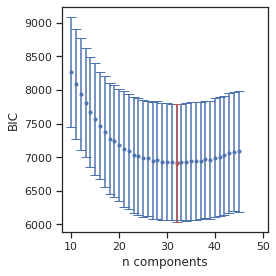

In [5]:
save_pth = '/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_NM_2019/'
plt.figure(figsize=(4,4))
plt.errorbar(x=X_mean.index.values,
             y=X_mean[field_name].values,
             yerr=X_sd[field_name].values,
             fmt='.',
             capsize=5)

plt.errorbar(x=best_n_components,
             y=X_mean[field_name][best_n_components],
             yerr=X_sd[field_name][best_n_components],
             fmt='.',
             c='r',
             capsize=3)

ax = plt.gca()
ax.set_xlabel('n components')
ax.set_ylabel('BIC')
#ax.set_ylim(1000,5600)
ax.set_xlim(8,51)
ax.set_xticks(np.arange(10,51,10))
plt.tight_layout()
#plt.savefig(save_pth+'denovo_gmm_bic.png',dpi=300)

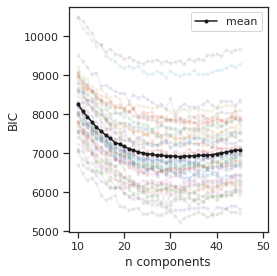

In [6]:
n_component_list=[]
plt.figure(figsize=(4,4))
for cv in range(44):
    Dd = D[D['cv']==cv]
    plt.plot(Dd['n_components'],Dd[field_name],'.-',alpha=0.1)
    temp = Dd.loc[Dd[field_name]==Dd[field_name].min()]
    n_component_list.append(temp['n_components'].values[0])
plt.plot(X_mean.index.values,X_mean[field_name].values,'.-',c='k',label='mean')
ax = plt.gca()
ax.set_xlabel('n components')
ax.set_ylabel('BIC')
#ax.set_ylim(1000,5600)
ax.set_xlim(8,51)
ax.set_xticks(np.arange(10,51,10))
plt.legend()
plt.tight_layout()
#plt.savefig(save_pth+'denovo_gmm_bic_individual.png',dpi=300)

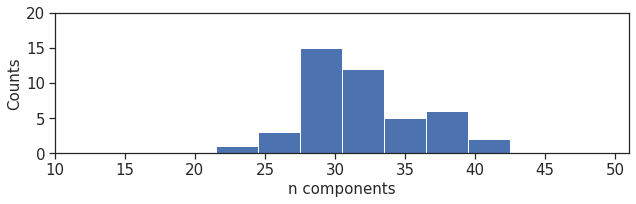

In [7]:
yy = n_component_list
plt.figure(figsize=(9,3))
plt.hist(yy,bins=np.arange(15,50,3)+0.5)
ax = plt.gca()
ax.set_xlabel('n components',fontsize=15)
ax.set_ylabel('Counts',fontsize=15)
ax.set_ylim(0,20)
ax.set_xlim(10,51)
ax.set_yticks(np.arange(0,21.5,5))
ax.set_yticklabels(np.arange(0,21.5,5).astype(int),fontsize=15)
ax.set_xticks(np.arange(10,51,5))
ax.set_xticklabels(np.arange(10,51,5).astype(int),fontsize=15)
plt.tight_layout()
plt.savefig(save_pth+'denovo_gmm_bic_best_n_component_counts_cpl_1-0.png',dpi=300)
plt.show()

In [ ]:
%reset

In [1]:
# load fitted gmm model from file
from sklearn import mixture
import scipy.io as sio
import pickle 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from timebudget import timebudget
%matplotlib inline

In [2]:
def confusion(a,b,unique_a,unique_b):
    """
    `a`, `b` : numpy arrays of labels for all the element.
    `unique_a`, `unique_b` : unique list of labels. Can have more entries than np.unique(a) and np.unique(b) 
    """
    assert a.shape==b.shape
    C = np.zeros((np.size(unique_a),np.size(unique_b)))
    for i,la in enumerate(unique_a):
        for j,lb in enumerate(unique_b):
            C[i,j] = np.sum(np.logical_and(a==la,b==lb))
    return C



def custom_heatmap(M,xdat,ydat,xdat_label_order,ydat_label_order,
                    xlabels=None,ylabels=None,
                    fig_width=9,fig_height=8,
                    vmin=0,vmax=100,):
    """
    `M` : Confusion matrix. Rows plotted on y axis, cols plotted on x-axis
    `xdat`,`ydat` : numpy arrays from which counts will be obtained
    `xdat_label_order`, `ydat_label_order` : order with which the histograms are plotted. Should match ordering of `M`
    """
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec
    import seaborn as sns
    sns.set(style='white')

    if xlabels is None:
        xlabels=['']*M.shape[1]
    if ylabels is None:
        ylabels=['']*M.shape[0]
        
    fig = plt.figure(figsize = (fig_width,fig_height),constrained_layout=True)
    gs = GridSpec(4, 4, figure=fig)
    ax1 = fig.add_subplot(gs[1:, 1:])
    ax2 = fig.add_subplot(gs[0, 1:])
    ax3 = fig.add_subplot(gs[1:, 0])

    sns.heatmap(M,annot=False,vmin=vmin,vmax=vmax,cbar_kws={"aspect":30,"shrink":.5,"use_gridspec":False,"location":"right"},ax=ax1,)
    ax1.set_yticks(np.arange(0,M.shape[0])+0.5)
    ax1.set_yticklabels(ylabels,rotation=0)

    ax1.set_xticks(np.arange(M.shape[1])+0.5)
    ax1.set_xticklabels(xlabels,rotation=90)
    ax1.xaxis.set_ticks_position('top')
    ax1.yaxis.set_ticks_position('left')

    sns.countplot(x=xdat,order=xdat_label_order,ax=ax2,color='grey')
    ax2.tick_params(labelbottom=False, labelleft=False)
    ax2.set_ylabel('')
    ax2.spines["left"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax2.spines["right"].set_visible(False)

    sns.countplot(y=ydat,order=ydat_label_order,ax=ax3,color='grey')
    ax3.invert_xaxis()
    ax3.yaxis.set_ticks_position('right')
    ax3.tick_params(labelbottom=False, labelleft=False,labelright=False)
    ax3.set_ylabel('')
    ax3.set_xlabel('')
    ax3.spines["left"].set_visible(False)
    ax3.spines["top"].set_visible(False)
    ax3.spines["bottom"].set_visible(False)

    plt.show()

In [3]:
representation_pth = '/home/rohan/Remote-AI/dat/result/TE_aug_decoders/'
gmm_pth = '/home/rohan/Remote-AI/dat/result/TE_aug_decoders/gmm_fits_us/'
origdata_pth = '/home/rohan/Remote-AI/dat/raw/patchseq-v4/PS_v5_beta_0-4_pc_scaled_ipxf_eqTE.mat'
O = sio.loadmat(origdata_pth,squeeze_me=True)

#Representations
alpha_T=1.0
alpha_E=1.0
lambda_TE=1.0
fiton='zT'
n_cvfolds = 44

In [4]:
#Load all CV sets 
with timebudget('load all cv sets'):
    CVdict={}
    key_list = ['zE','zT','train_ind','val_ind','test_ind']

    for cv in range(n_cvfolds):
        cvfold_fname='v3_Edat_pcipfx_aT_'+str(alpha_T)+\
                    '_aE_'+str(alpha_E)+\
                    '_cs_'+str(lambda_TE)+\
                    '_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+\
                    '_ri_0500_ft-summary'
        cvfold_fname=cvfold_fname.replace('.','-')+'.mat'
        X = sio.loadmat(representation_pth+cvfold_fname,squeeze_me=True)
        CVdict[cv] = {key:X[key] for key in key_list}
        del X

load all cv sets took 10.548sec


**Get cluster labels based on GMM fit**

In [5]:
with timebudget('fit gmm'):
    best_n_components = 30
    for cv in CVdict.keys():

        fname = 'gmmfit_aT_{:.1f}_aE_{:.1f}_cs_{:.1f}_cv_{:d}_ld_3_ne_1500_fiton_zT_n_{:d}.pkl'.format(alpha_T,
                                                                                                       alpha_E,
                                                                                                       lambda_TE,
                                                                                                       cv,
                                                                                                       best_n_components)
        with open(gmm_pth+fname, 'rb') as fid:
            gmm = pickle.load(fid)

        #Label predictions using GMM fits:
        CVdict[cv]['ccT_lbl'] = gmm.predict(CVdict[cv]['zT'])
        CVdict[cv]['ccE_lbl'] = gmm.predict(CVdict[cv]['zE'])

fit gmm took 902.57ms


**Cross modal consistency based on cosine similarity for a single fold**

In [7]:
from scipy.cluster import hierarchy

cv=0
C = confusion(a=CVdict[cv]['ccE_lbl'],
              b=CVdict[cv]['ccT_lbl'],
              unique_a=np.arange(best_n_components),
              unique_b=np.arange(best_n_components))

D = hierarchy.distance.pdist(C,metric='cosine')
Z = hierarchy.ward(D)
ordr = hierarchy.leaves_list(Z)
C_ordered = C[np.ix_(ordr,ordr)]
gmm_labels_ordered = ['C-{:02d}'.format(n) for n in np.arange(0,best_n_components)[ordr].tolist()]

In [8]:
order_x = np.arange(0,best_n_components)[ordr]
order_y = np.arange(0,best_n_components)[ordr]

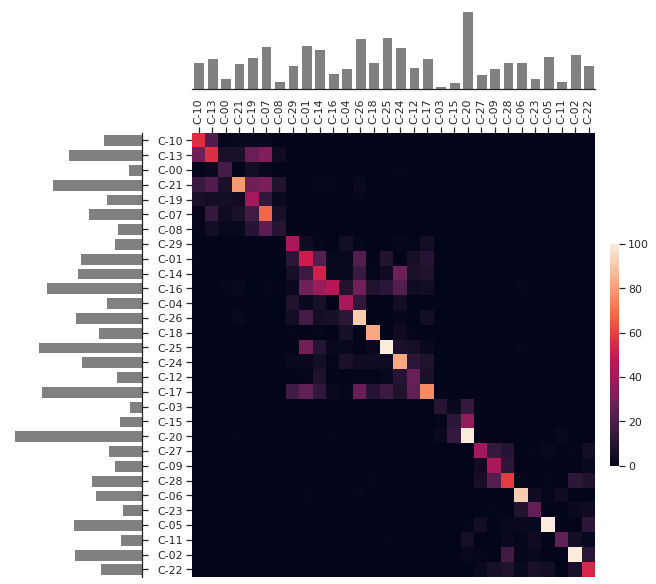

In [9]:
custom_heatmap(M=C_ordered,
                xlabels=gmm_labels_ordered,
                ylabels=gmm_labels_ordered,
                xdat=CVdict[cv]['ccT_lbl'],
                xdat_label_order=order_x,
                ydat=CVdict[cv]['ccE_lbl'],
                ydat_label_order=order_y)

In [10]:
from scipy.optimize import linear_sum_assignment

In [11]:
t_types = sorted(list(set(zip(O['cluster_id'],O['cluster']))), key=lambda x:x[0])
t_types = [x[1] for x in t_types]

In [12]:
C = confusion(a=O['cluster'].copy()[CVdict[cv]['train_ind']],
              b=CVdict[cv]['ccT_lbl'][CVdict[cv]['train_ind']],
              unique_a=t_types,
              unique_b=np.arange(best_n_components))

row_ind,col_ind = linear_sum_assignment(-C)
C_ordered = C[:,col_ind]
gmm_labels_ordered = ['C-{:02d}'.format(n) for n in np.arange(0,best_n_components)[col_ind].tolist()]
order_y = np.arange(0,best_n_components)[col_ind]

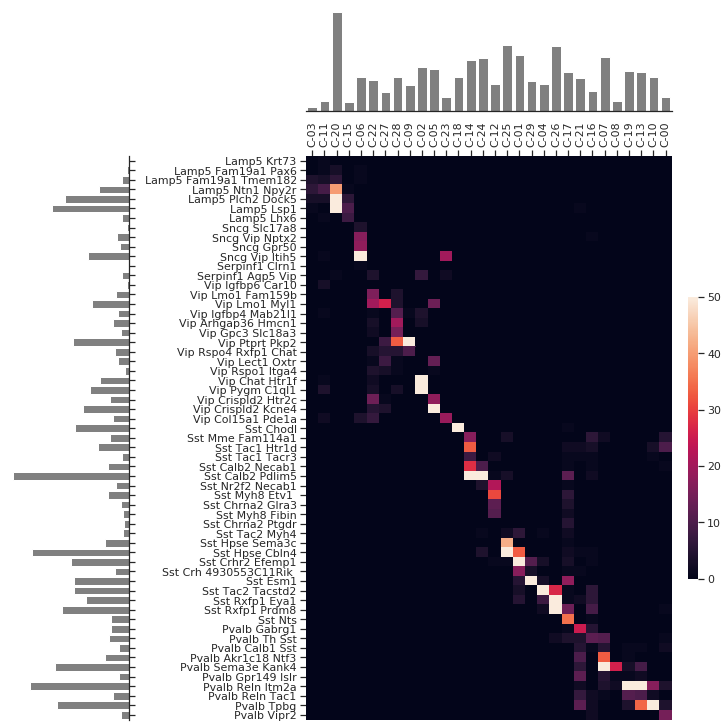

In [13]:
custom_heatmap(M=C_ordered,
                xlabels=gmm_labels_ordered,
                ylabels=t_types,
                xdat=CVdict[cv]['ccT_lbl'],
                xdat_label_order=order_y,
                ydat=O['cluster'],
                ydat_label_order=t_types,
                fig_width=10,fig_height=14,
                vmin=0,vmax=50)

**Pooling validation folds**

 - Take a CVset
 - Find the ordering based on best match with t-types, using training set data
 - Label the gmm fitted clusters according to this
 

In [14]:
with timebudget('Assignment: '):
    for cv in CVdict.keys():
        C = confusion(a=O['cluster'].copy()[CVdict[cv]['train_ind']],
                      b=CVdict[cv]['ccT_lbl'][CVdict[cv]['train_ind']],
                      unique_a=t_types,
                      unique_b=np.arange(best_n_components))

        row_ind,col_ind = linear_sum_assignment(-C)
        C_ordered = C[:,col_ind]
        order_y = np.arange(0,best_n_components)[col_ind]

        CVdict[cv]['ccT_lbl_matched'] = CVdict[cv]['ccT_lbl'].copy()
        CVdict[cv]['ccE_lbl_matched'] = CVdict[cv]['ccE_lbl'].copy()
        
        for i in range(best_n_components):
            ind = CVdict[cv]['ccT_lbl'] == order_y[i]
            CVdict[cv]['ccT_lbl_matched'][ind] = i

            ind = CVdict[cv]['ccE_lbl'] == order_y[i]
            CVdict[cv]['ccE_lbl_matched'][ind] = i

Assignment:  took 4.963sec


All the labels are ordered. Now we have to pool the results acros validation data. 

In [15]:
Combined_C_t_type = np.zeros((len(t_types),best_n_components))
Combined_C_consistency = np.zeros((best_n_components,best_n_components))
Combined_ccT_lbl = []
Combined_ccE_lbl = []
for cv in CVdict.keys():

    C = confusion(a=O['cluster'].copy()[CVdict[cv]['val_ind']],
                          b=CVdict[cv]['ccT_lbl_matched'][CVdict[cv]['val_ind']],
                          unique_a=t_types,
                          unique_b=np.arange(best_n_components))

    Combined_C_t_type = Combined_C_t_type+C
    del C
    
    Combined_ccT_lbl.append(CVdict[cv]['ccT_lbl_matched'])
    Combined_ccE_lbl.append(CVdict[cv]['ccE_lbl_matched'])
    
    C = confusion(a=CVdict[cv]['ccE_lbl_matched'][CVdict[cv]['val_ind']],
                    b=CVdict[cv]['ccT_lbl_matched'][CVdict[cv]['val_ind']],
                    unique_a=np.arange(best_n_components),
                    unique_b=np.arange(best_n_components))
    
    Combined_C_consistency = Combined_C_consistency + C
    del C
    
Combined_ccT_lbl = np.concatenate(Combined_ccT_lbl)
Combined_ccE_lbl = np.concatenate(Combined_ccE_lbl)

**Consistency across the modalities, after aligning the unsupervised types with t-types**

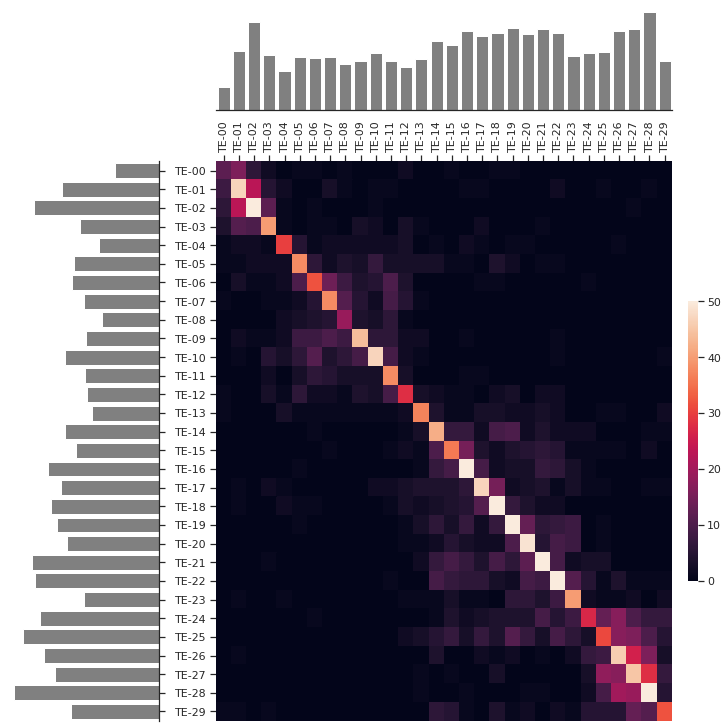

In [16]:
TE_labels_denovo = ['TE-{:02d}'.format(n) for n in np.arange(0,best_n_components).tolist()]
#ax = sns.heatmap(Combined_C,annot=False,vmin=0,vmax=10,cbar_kws={"aspect":30,"shrink":.9})
custom_heatmap(M=Combined_C_consistency,
                xlabels=TE_labels_denovo,
                ylabels=TE_labels_denovo,
                xdat=Combined_ccT_lbl,
                xdat_label_order=np.arange(0,best_n_components),
                ydat=Combined_ccE_lbl,
                ydat_label_order=np.arange(0,best_n_components),
                fig_width=10,fig_height=10,
                vmin=0,vmax=50)

**Consistency with t-types**

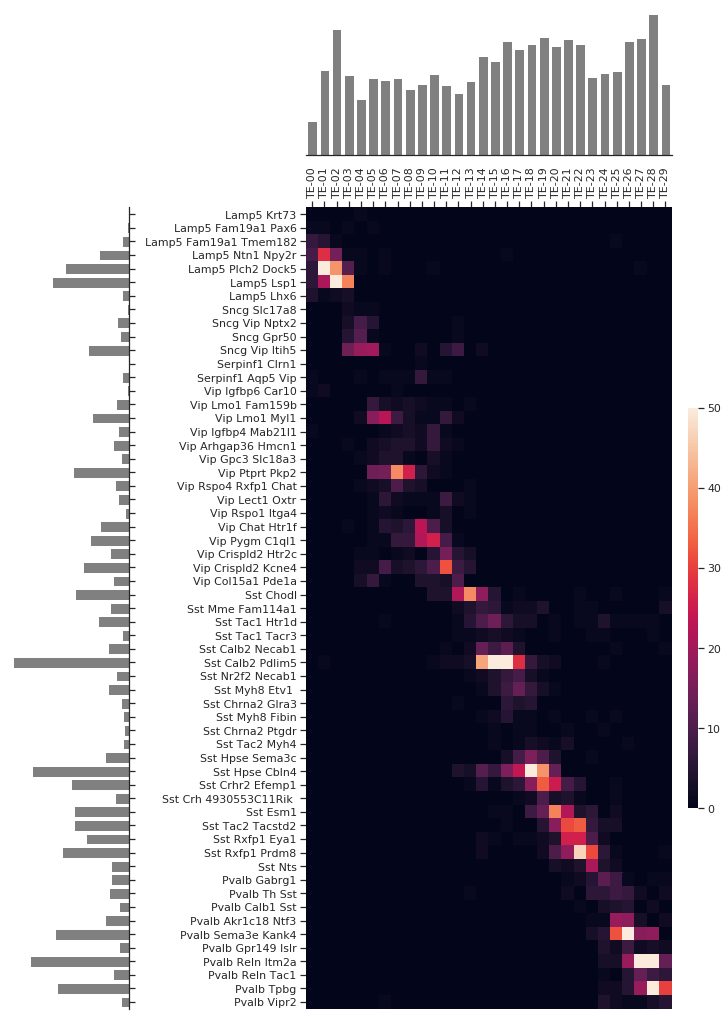

In [17]:
TE_labels_denovo = ['TE-{:02d}'.format(n) for n in np.arange(0,best_n_components).tolist()]
#ax = sns.heatmap(Combined_C,annot=False,vmin=0,vmax=10,cbar_kws={"aspect":30,"shrink":.9})
custom_heatmap(M=Combined_C_t_type,
                xlabels=TE_labels_denovo,
                ylabels=t_types,
                xdat=Combined_ccT_lbl,
                xdat_label_order= np.arange(0,best_n_components),
                ydat=O['cluster'],
                ydat_label_order=t_types,
                fig_width=10,fig_height=14,
                vmin=0,vmax=50)

**If want merged labels from Tasic hierarchy**

In [16]:
list_changes = htree.get_mergeseq()

for m in range(1,40):
    orig_labels = O['cluster'].copy()
    new_labels = do_merges(orig_labels, list_changes=list_changes, n_merges=m)
    if np.unique(new_labels).size==best_n_components:
        print('n_merges = {} for {} clusters'.format(m,best_n_components))
        break
        
orig_labels = O['cluster'].copy()
T_merged_labels = do_merges(orig_labels, list_changes=list_changes, n_merges=20)

htree.plot((15,5),fontsize=12,skeletoncol='#000000',ls='-',txtleafonly=True)
ax = plt.gca()
ax.set_xlim(30,95)
ax.axis('off')

for l in np.unique(new_labels):
    plt.plot(htree.x[htree.child==l],htree.y[htree.child==l],marker='.',markersize=10,c='#FF0000')
plt.tight_layout()

In [ ]:
def set_ME_labels(O):
    import scipy.io as sio
    import pandas as pd

    dir_pth = {}
    #/allen/programs/celltypes/workgroups/ivscc/nathang/me_clust_output/inh_met_mouse_me_clustering/refined_text_labels.csv
    dir_pth['data'] = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/'
    ME = pd.read_csv(dir_pth['data']+'refined_text_labels.csv')
    ME.columns = ['spec_id_label','cluster']
    MEdict = {'spec_id_label':ME['spec_id_label'].values,'cluster':ME['cluster'].values}w

    ind = np.isin(O['E_spec_id_label'],MEdict['spec_id_label'])
    print('{:d} cells have ME labels'.format(np.sum(ind)))
    O['ME_cluster'] = np.array(['NA']*np.size(O['E_spec_id_label']),dtype='object')
    for e in O['E_spec_id_label']:
        set_ind = (MEdict['spec_id_label']==e)
        if np.sum(set_ind)==1:
            O['ME_cluster'][O['E_spec_id_label']==e] = MEdict['cluster'][set_ind]
    return O

In [18]:
#Unusual python behavior:
X = np.random.rand(10,10)
Xnorm = np.divide(X,np.expand_dims(np.sum(X,axis=1),-1))
print(np.sum(Xnorm,axis=1)==1.0)
#--> use: np.allclose

[False False False  True  True  True False False  True  True]
